In [176]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

path = r"Data\\"

In [182]:
from TransformData import transform_data
data_generator = transform_data(path = path + 'train.csv')
data = data_generator.get_data(train_or_analysis = 'train')

In [185]:
sum(data.SalePrice <= np.quantile(data['SalePrice'], 0.99))

1430

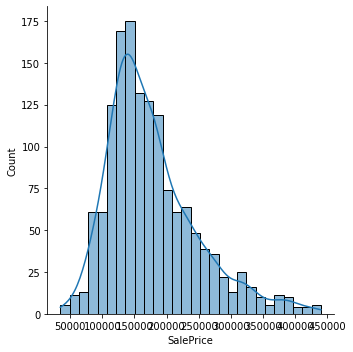

In [184]:
data = data.loc[data['SalePrice'] <= np.quantile(data['SalePrice'], 0.99)].copy()
sns.displot(data.SalePrice, kde = True);

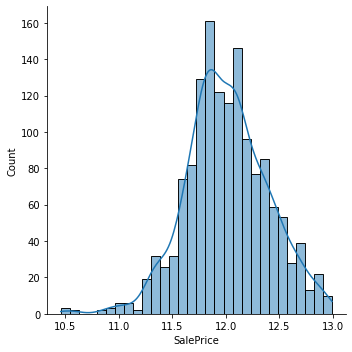

In [186]:
data.SalePrice = np.log(data.SalePrice)
sns.displot(data.SalePrice, kde = True);

In [187]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score


params = {'lambda': 3.792404253903758, 'alpha': 3.720406654006611, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.027569142191457396, 'max_depth': 7, 'random_state': 1, 'min_child_weight': 26}
params2 = {'lambda': 5.08745375747522, 'alpha': 1.3840557746026854, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.0705794117436359, 'max_depth': 5, 'random_state': 1, 'min_child_weight': 9}
x = data.drop('SalePrice', axis = 1)
y = data['SalePrice']

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.3, random_state=1)
reg = XGBRegressor(eval_metric= 'rmse', n_estimators = 1433, **params2)#, early_stopping_rounds = 50, **params)
reg.fit(x_train, y_train, 
        #eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=100)
y_pred = reg.predict(x_test)

In [188]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('---------test------------')
print("R²: %.2f" % r2)
print("MSE: %.2f" % mse)
print("RMSE: %.4f" % np.sqrt(mse))
print("MAPE: %.2f" % (mape * 100) + '%')

---------test------------
R²: 0.88
MSE: 0.02
RMSE: 0.1331
MAPE: 0.79%


In [189]:
tests = cross_val_score(reg, x_test, y_test, cv = 5, n_jobs = -1,scoring = 'neg_root_mean_squared_error')
np.mean(tests)

-0.12372710252057013

In [190]:
importances = pd.DataFrame(columns = ['feature_importances'], data = reg.feature_importances_, index = reg.feature_names_in_).sort_values(by = 'feature_importances', ascending = False)


zero_importance= list(importances.loc[importances['feature_importances'] == 0].reset_index()['index'])
importances

,feature_importances
GarageCond_TA,0.127297
GarageCars,0.098654
CentralAir_N,0.094806
OverallQual,0.070866
GarageType_No Garage,0.054712
...,...
BsmtFinType2_GLQ,0.000000
BsmtFinType2_LwQ,0.000000
BsmtFinType2_No Basement,0.000000
HouseStyle_2.5Fin,0.000000


In [191]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression

params = {'lambda': 3.792404253903758, 'alpha': 3.720406654006611, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.027569142191457396, 'max_depth': 7, 'random_state': 1, 'min_child_weight': 26}
params2 = {'lambda': 5.08745375747522, 'alpha': 1.3840557746026854, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.0705794117436359, 'max_depth': 5, 'random_state': 1, 'min_child_weight': 9}
x = data.drop('SalePrice', axis = 1)
x = x.drop(zero_importance, axis = 1)
y = data['SalePrice']
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.3, random_state=1)
reg = XGBRegressor(eval_metric= 'rmse', n_estimators = 1433, **params2)#, early_stopping_rounds = 50, **params)
reg.fit(x, y, 
        #eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=100)
y_pred = reg.predict(x_test)

In [192]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('---------test------------')
print("R²: %.2f" % r2)
print("MSE: %.2f" % mse)
print("RMSE: %.4f" % np.sqrt(mse))
print("MAPE: %.2f" % (mape * 100) + '%')

---------test------------
R²: 0.98
MSE: 0.00
RMSE: 0.0563
MAPE: 0.33%


In [193]:
tests = cross_val_score(reg, x_test, y_test, cv = 5, n_jobs = -1,scoring = 'neg_root_mean_squared_error')
np.mean(tests)

-0.1258060400926535

In [18]:
def objective(trial):
    x = data.drop('SalePrice', axis = 1)
    y = data['SalePrice']
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.3, random_state=1)
    param = {
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1),
        'n_estimators': 10000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'random_state': trial.suggest_categorical('random_state', [1]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = XGBRegressor(**param, eval_metric= 'rmse')  
    model.fit(x_train,y_train,eval_set=[(x_train, y_train), (x_test, y_test)],verbose=False)
    preds = model.predict(x_test)
    tests = cross_val_score(model, x_test, y_test, cv = 5, n_jobs = -1,scoring = 'neg_root_mean_squared_error')
    return np.mean(tests)

In [19]:
import optuna

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-05-07 23:58:47,519] A new study created in memory with name: no-name-c3b73186-1af7-4277-baf5-e016ddddf882
[I 2023-05-07 23:59:51,993] Trial 0 finished with value: -0.39013843290074224 and parameters: {'lambda': 6.843764118504788, 'alpha': 3.2519994484812527, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.05026769979493771, 'max_depth': 11, 'random_state': 1, 'min_child_weight': 261}. Best is trial 0 with value: -0.39013843290074224.
[I 2023-05-08 00:00:50,517] Trial 1 finished with value: -0.1357397865956603 and parameters: {'lambda': 3.622943473920016, 'alpha': 6.129612529893727, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.051247952069980146, 'max_depth': 5, 'random_state': 1, 'min_child_weight': 33}. Best is trial 1 with value: -0.1357397865956603.
[I 2023-05-08 00:01:51,587] Trial 2 finished with value: -0.1700286569475164 and parameters: {'lambda': 6.828503879440374, 'alpha': 9.586577652292213, 'colsample_bytree': 0.6, 'subsample': 0.6, 'lea

Number of finished trials: 200
Best trial: {'lambda': 5.08745375747522, 'alpha': 1.3840557746026854, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.0705794117436359, 'max_depth': 5, 'random_state': 1, 'min_child_weight': 9}


In [200]:
data_generator = transform_data(path = path + 'test.csv')
test = data_generator.get_data(train_or_analysis = 'train')
test = test.set_index('Id')
test

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1464,60,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1465,120,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,21.0,1936,4,7,1970,1970,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2916,160,21.0,1894,4,5,1970,1970,0.0,252.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2917,20,160.0,20000,5,7,1960,1996,0.0,1224.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [201]:
missing_columns = [i for i in x.columns if i not in test.columns]
for i in missing_columns:
    test[i] = 0
test = test[x.columns]
preds = np.exp(reg.predict(test))

In [202]:
test.drop('Id', axis = 1).reset_index()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,Fence_MnPrv,Fence_No Fence,MiscFeature_No Misc,MiscFeature_Shed,SaleType_COD,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Normal,SaleCondition_Partial
0,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1464,60,78.0,9978,6,6,1998,1998,20.0,602.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1465,120,43.0,5005,8,5,1992,1992,0.0,263.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,21.0,1936,4,7,1970,1970,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1455,2916,160,21.0,1894,4,5,1970,1970,0.0,252.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1456,2917,20,160.0,20000,5,7,1960,1996,0.0,1224.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1457,2918,85,62.0,10441,5,5,1992,1992,0.0,337.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [203]:
output = pd.DataFrame({'Id': test.drop('Id', axis = 1).reset_index()['Id'],
                       'SalePrice': preds})
outpu = output.round(2)
output

,Id,SalePrice
0,1461,123341.656250
1,1462,162590.031250
2,1463,183841.640625
3,1464,195949.015625
4,1465,181765.156250
...,...,...
1454,2915,82865.968750
1455,2916,82542.835938
1456,2917,166911.015625
1457,2918,116151.882812


In [198]:
output.to_csv(path + 'submission.csv', index= False)

In [199]:
output

,Id,SalePrice
0,1461,123341.656250
1,1462,162590.031250
2,1463,183841.640625
3,1464,195949.015625
4,1465,181765.156250
...,...,...
1454,2915,82865.968750
1455,2916,82542.835938
1456,2917,166911.015625
1457,2918,116151.882812
